In [1]:
#put the these lines before importing any module from keras.
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0" #only the gpu 0 is allowed

sess = tf.Session(config=config)
graph = tf.get_default_graph()
set_session(sess)

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-

['/job:localhost/replica:0/task:0/device:GPU:0']

In [11]:
import os
from os.path import join
import numpy as np
import keras
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed, concatenate, Conv2DTranspose, Add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model
from keras_segmentation.models.model_utils import get_segmentation_model

In [3]:
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

0006R0_f03570.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


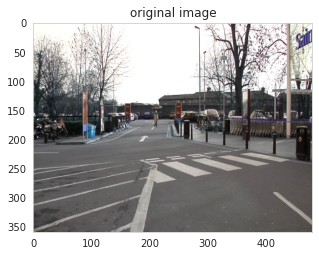

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


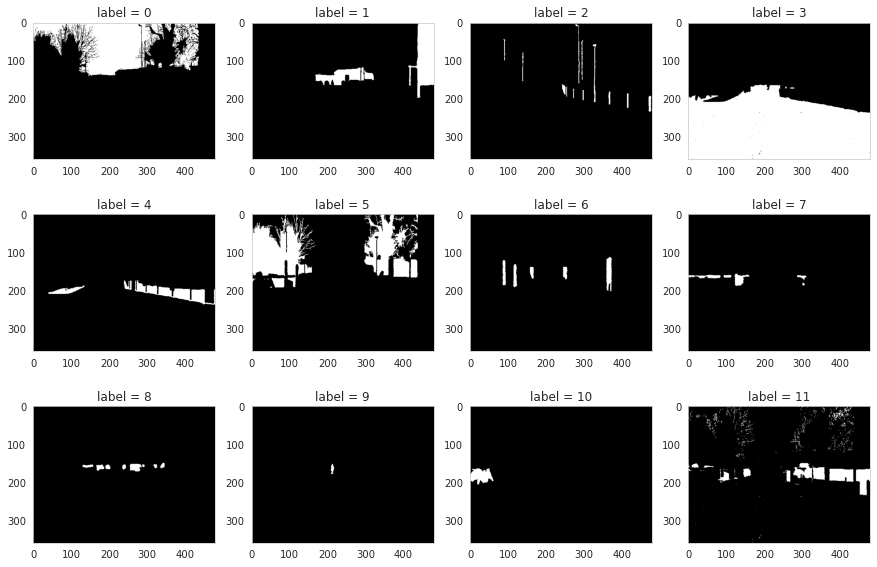

In [4]:
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})

ldseg = np.array(os.listdir(dir_seg))
## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

In [5]:
def give_color_to_seg_img(seg, n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

In [6]:
# Prepare Train/Test/Label Dataset
input_height , input_width = 224 , 224
output_height , output_width = 224 , 224

images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


In [7]:
import sys, time, warnings
warnings.filterwarnings("ignore")

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
keras version 2.3.1
tensorflow version 1.14.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape

(293, 224, 224, 3)

In [21]:
# Alternative Split Dataset
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0], int(X.shape[0]*train_rate), replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


## FCN

In [9]:
## location of VGG weights
VGG_Weights_path = "checkpoints/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [10]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = input_height, 
             input_width  = input_width)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

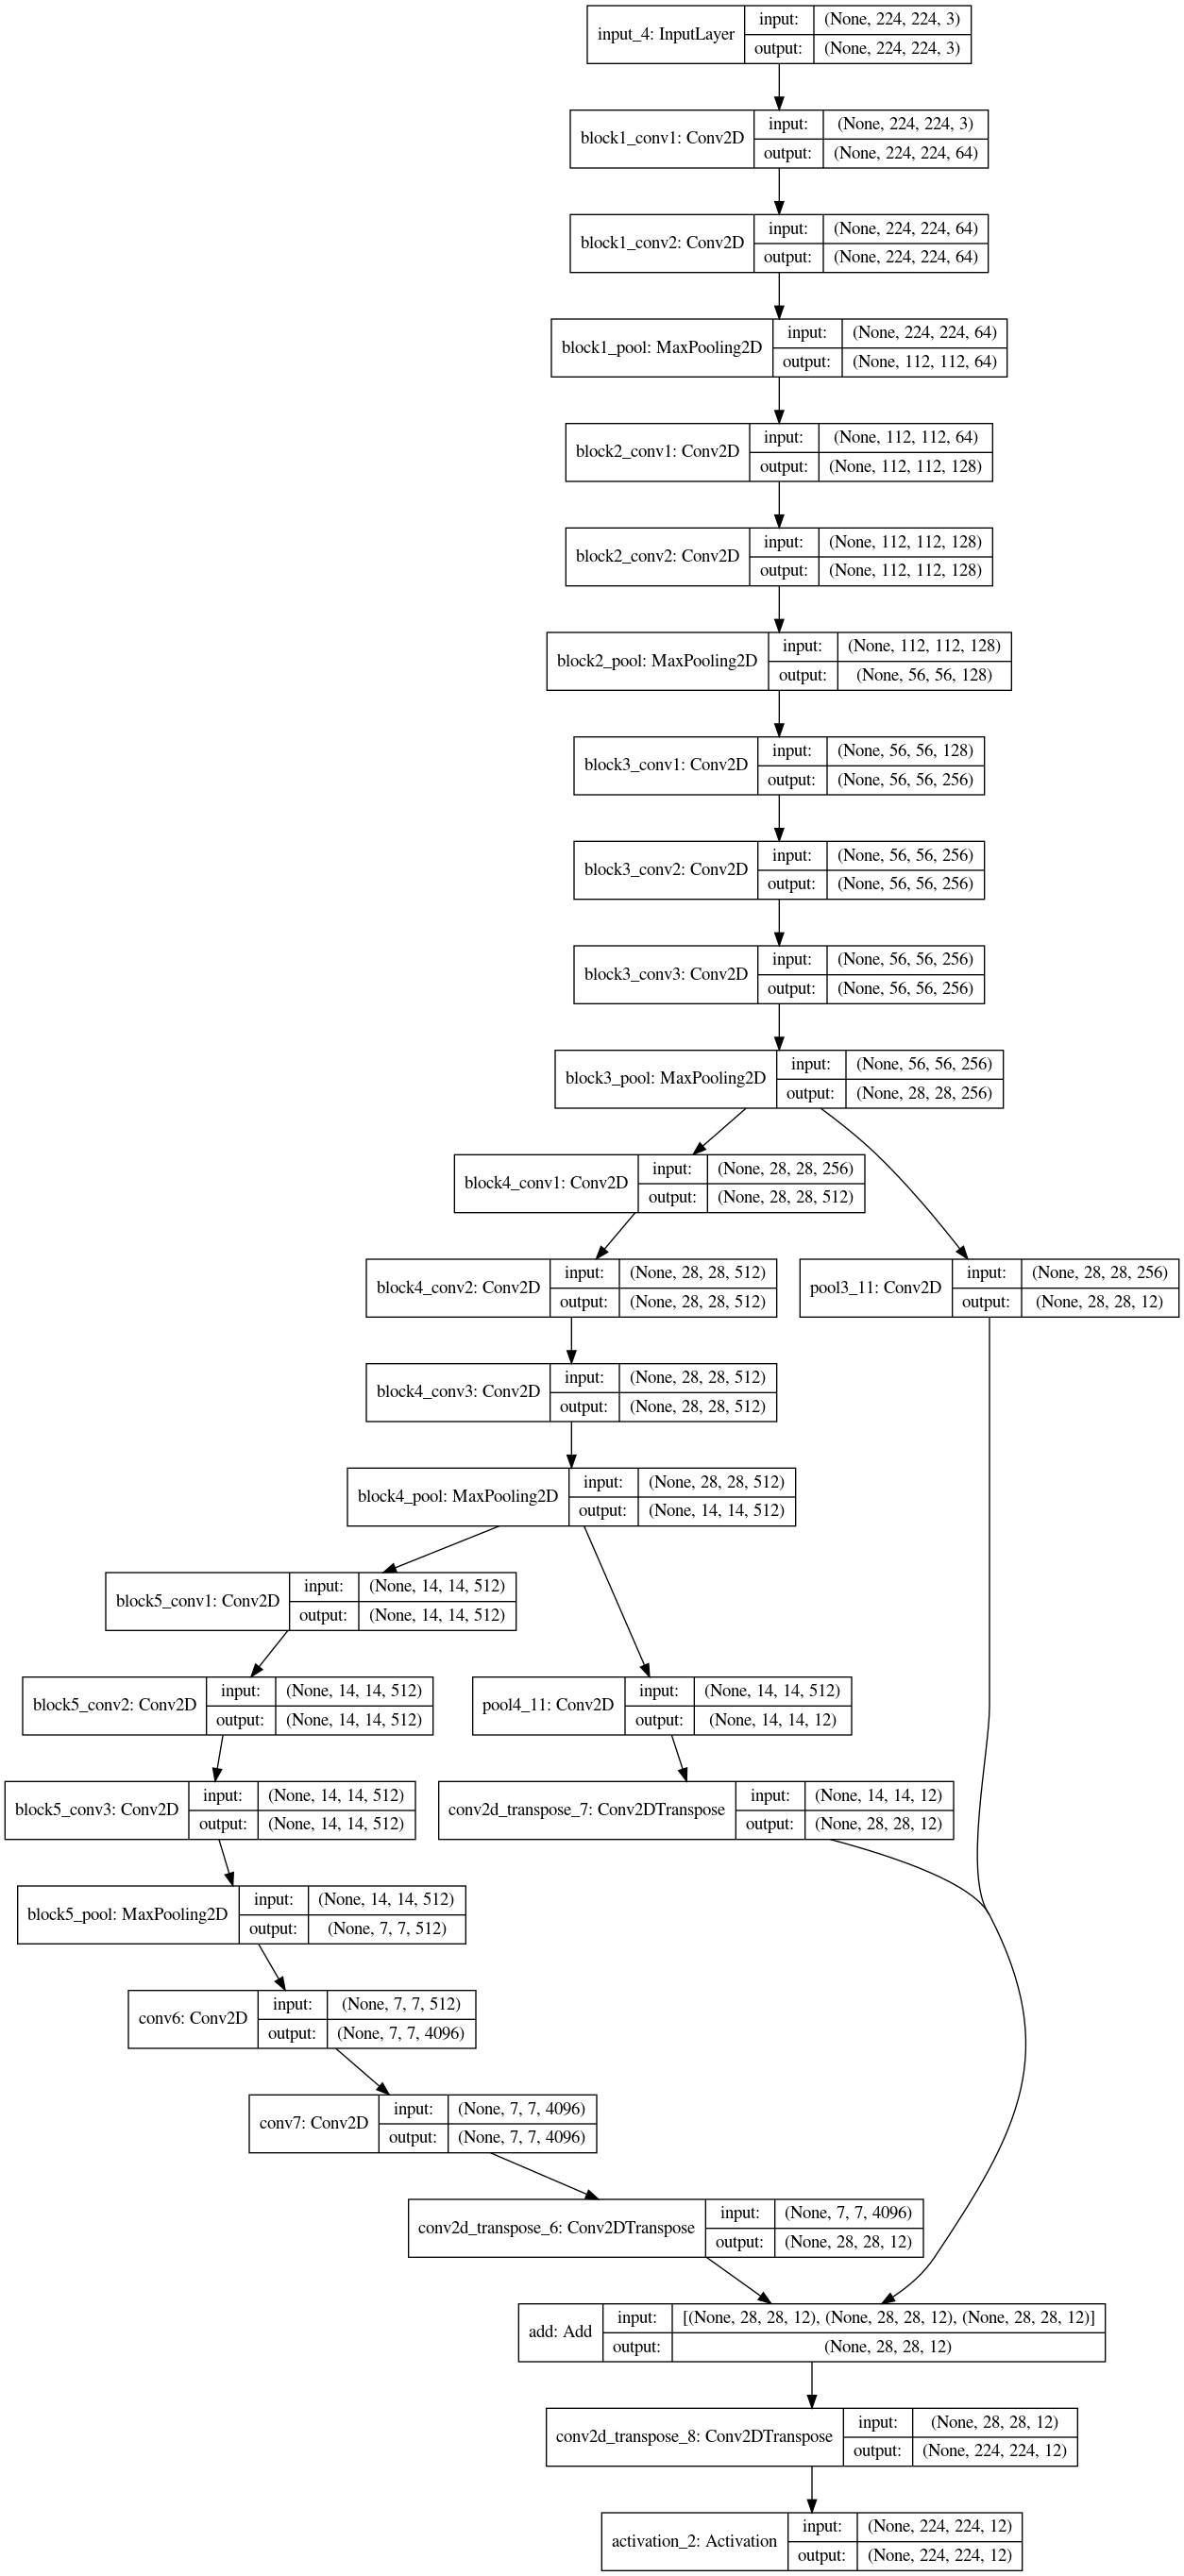

In [33]:
plot_model(model, to_file='FCN8.png', show_shapes=True)

In [14]:
# Optimizer
sgd = keras.optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

epochs = 5
batch_size = 1

global sess
global graph
with graph.as_default():
    set_session(sess)
    history = model.fit(X_train, y_train,
                      validation_data=(X_test,y_test),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Train on 293 samples, validate on 74 samples
Epoch 1/5


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[1,1,256,12] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/SGD/mul_134}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Mean_1/_447]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[1,1,256,12] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/SGD/mul_134}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

## Ready-to-use Segmentaion Models

In [22]:
from keras_segmentation.models.unet import unet_mini, vgg_unet

model0 = unet_mini(n_classes=12 ,  input_height=input_height, input_width=input_width )
model0.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 224, 224, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 224, 224, 32) 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 224, 224, 32) 9248        dropout_11[0][0]                 
___________________________________________________________________________________________

In [42]:
y_train_flat = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])
y_test_flat = y_test.reshape(y_test.shape[0], -1 , y_test.shape[-1])

In [43]:
y_train_flat.shape

(311, 50176, 12)

In [46]:
# Optimizer
sgd = keras.optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model0.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

epochs = 10
batch_size = 3

global sess
global graph
with graph.as_default():
    set_session(sess)
    history = model0.fit(x=X_train, y=y_train_flat,
                       validation_data=(X_test, y_test_flat), epochs=epochs, batch_size=batch_size, verbose=1)

Train on 311 samples, validate on 56 samples
Epoch 1/10
311/311 [==============================] - 17s 56ms/step - loss: 1.6951 - accuracy: 0.4411 - val_loss: 1.4829 - val_accuracy: 0.5266
Epoch 2/10
311/311 [==============================] - 12s 37ms/step - loss: 1.3859 - accuracy: 0.5533 - val_loss: 1.6639 - val_accuracy: 0.5135
Epoch 3/10
311/311 [==============================] - 11s 37ms/step - loss: 1.2155 - accuracy: 0.6267 - val_loss: 1.3055 - val_accuracy: 0.5732
Epoch 4/10
311/311 [==============================] - 12s 37ms/step - loss: 1.1393 - accuracy: 0.6498 - val_loss: 1.1921 - val_accuracy: 0.6248
Epoch 5/10
311/311 [==============================] - 12s 38ms/step - loss: 1.0711 - accuracy: 0.6649 - val_loss: 1.1892 - val_accuracy: 0.6307
Epoch 6/10
311/311 [==============================] - 12s 37ms/step - loss: 1.0391 - accuracy: 0.6723 - val_loss: 1.0988 - val_accuracy: 0.6458
Epoch 7/10
311/311 [==============================] - 12s 37ms/step - loss: 1.0134 - accura

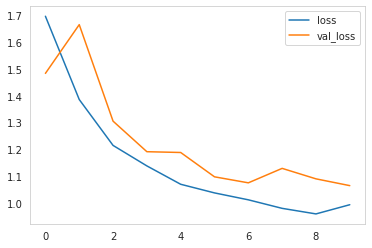

In [47]:
for key in ['loss', 'val_loss']:
    plt.plot(history.history[key],label=key)
plt.legend()
plt.show()

## Validation

In [77]:
y_pred = model0.predict(X_test[0:1]).reshape(-1, 224, 224, 12)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(56, 224, 224) (1, 224, 224)


In [78]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=398598, #FP=538282, #FN=48438, IoU=0.405
class 01: #TP=276547, #FP=449157, #FN=354304, IoU=0.256
class 02: #TP=     0, #FP=     0, #FN=33853, IoU=0.000
class 03: #TP=830865, #FP=298263, #FN=55789, IoU=0.701
class 04: #TP=  1484, #FP= 13076, #FN=131715, IoU=0.010
class 05: #TP=    66, #FP=   494, #FN=313793, IoU=0.000
class 06: #TP=     0, #FP=     0, #FN=41917, IoU=0.000
class 07: #TP=     0, #FP=     0, #FN=44490, IoU=0.000
class 08: #TP=   594, #FP=  2430, #FN=138205, IoU=0.004
class 09: #TP=     0, #FP=     0, #FN=18385, IoU=0.000
class 10: #TP=     0, #FP=     0, #FN=15316, IoU=0.000
class 11: #TP=     0, #FP=     0, #FN=105497, IoU=0.000
_________________
Mean IoU: 0.115


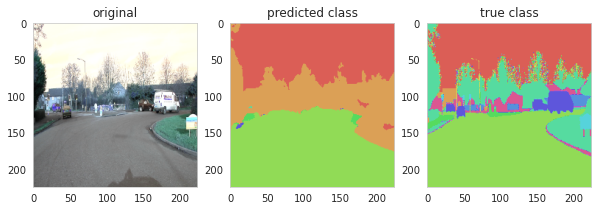

In [79]:
shape = (224,224)
n_classes= 12

for i in range(1):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()

In [55]:
model0.save_weights(join('checkpoints', 'mini_unet0'))

### Load Weights from Checkpoints

In [57]:
# Load checkpoints of model_weights
model0.load_weights(join('checkpoints', 'mini_unet0'))

In [59]:
data_dir = 'dataset1'

In [73]:
test_img_lst = []
for filename in os.listdir(join(data_dir, "images_prepped_test")):
    test_img_lst.append(filename)
test_img0 = cv2.imread(join(data_dir, "images_prepped_test", test_img_lst[0]))

In [74]:
img0 = cv2.resize(test_img0, (input_height, input_width))
results = model0.predict(img0.reshape(1, input_height, input_width, 3))

In [75]:
res_img = results.reshape(input_height, input_width, n_classes)

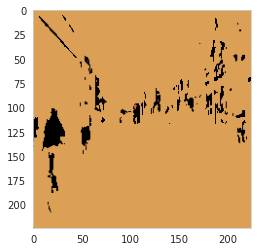

In [76]:
plt.imshow(give_color_to_seg_img(res_img, n_classes))
plt.show()